In [76]:
import pandas as pd
import numpy as np



def create_strategy_df(btc_df, eth_df, trigger_pnl, target_profit, stop_loss, output_file, save_result=False):
    
    df = pd.DataFrame()
    df['date'] = eth_df['date']
    df['btc_price'] = btc_df['close']
    df['btc_pnl'] = btc_df['p_n_l']
    df['eth_price'] = eth_df['close']
    df['eth_pnl'] = eth_df['p_n_l']
    df['signal'] = ''
    df['return'] = 0.0
    df['cumulative_returns'] = 1.0
    
    signal = 0
    entry_price = 0
    position_open = False
    
    for i in range(len(df)):
        if not position_open:
            if df.loc[i, 'btc_pnl'] >= trigger_pnl:
                signal = 1
                entry_price = df.loc[i, 'eth_price']
                df.loc[i, 'signal'] = 'LONG'
                position_open = True

            elif df.loc[i, 'btc_pnl'] <= -trigger_pnl:
                signal = -1
                entry_price = df.loc[i, 'eth_price']
                df.loc[i, 'signal'] = 'SHORT'
                position_open = True
        
        else:
            if signal == 1: 
                current_pnl = ((df.loc[i, 'eth_price'] - entry_price) / entry_price) * 100
                df.loc[i, 'track_return'] = current_pnl
                df.loc[i, 'signal'] = 'LONG'
                
            elif signal == -1:  
                current_pnl = ((entry_price - df.loc[i, 'eth_price']) / entry_price) * 100
                df.loc[i, 'track_return'] = current_pnl
                df.loc[i, 'signal'] = 'SHORT'
            
            if current_pnl >= target_profit or current_pnl <= -stop_loss:
                df.loc[i, 'signal'] = ''
                signal = 0
                entry_price = 0
                position_open = False
                df.loc[i, 'return'] = current_pnl

    df['cumulative_returns'] = (1 + df['return']/100).cumprod()
    total_return = (df['cumulative_returns'].iloc[-1] - 1)*100
    if save_result is True:
        df.to_csv(output_file, index=False)
        print(f"\nStrategy results saved to: {output_file}")


    
    return df, total_return






Best combination: X=0.2, Y=0.9, Return=278.22


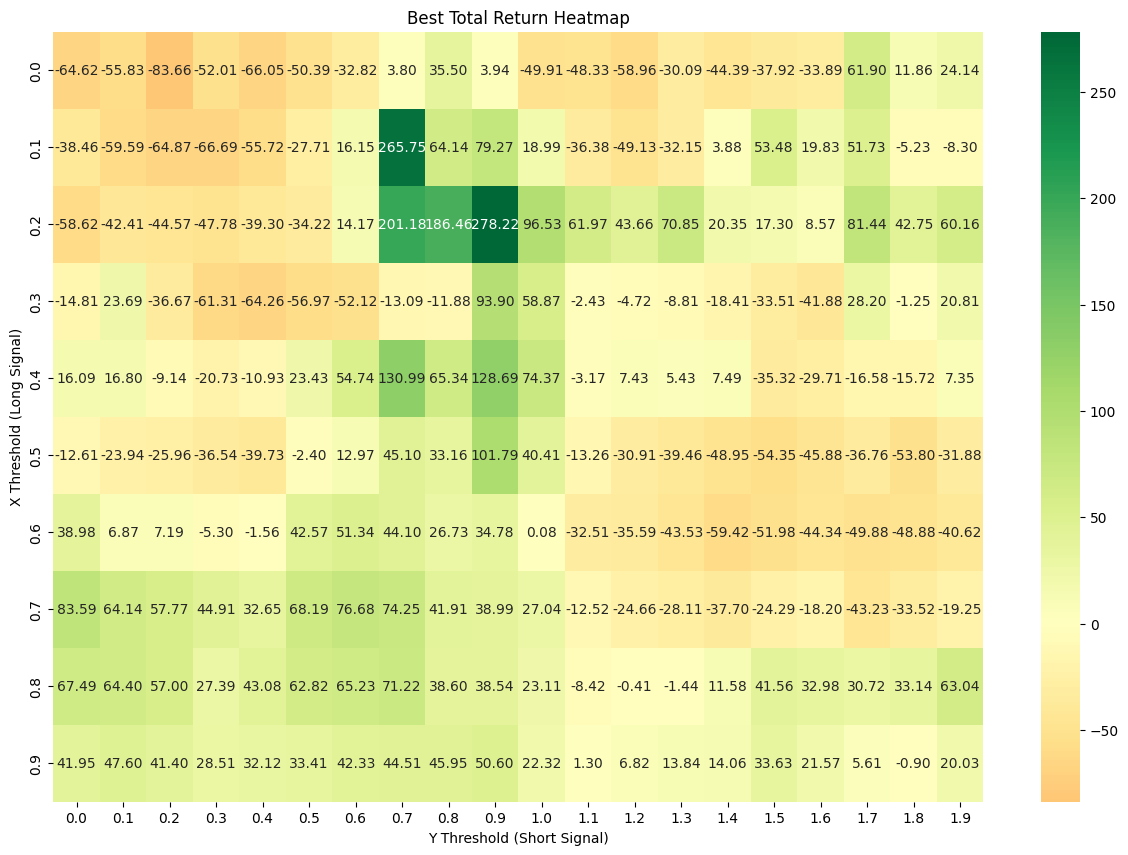

In [77]:
# here we generate the sharpe ratio heat map, cell id: 7

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def generate_total_return_heatmap(btc_df, eth_df, stop_loss,
                           x_range=np.arange(0, 1, 0.1), 
                           y_range=np.arange(0, 2, 0.1), show_graph=False):

    results = []
    
    for x in x_range:
        row = []
        for y in y_range:
            df, total_return = create_strategy_df(btc_df, eth_df, x, y, stop_loss, "", save_result=False)
            row.append(total_return)
        results.append(row)
    

    
    # Find best combination
    results_array = np.array(results)
    max_idx = np.unravel_index(results_array.argmax(), results_array.shape)
    best_x = x_range[max_idx[0]]
    best_y = y_range[max_idx[1]]
    best_return = results_array[max_idx]
    
    if show_graph == True:
        plt.figure(figsize=(15, 10))
        sns.heatmap(results, 
        xticklabels=[f'{y:.1f}' for y in y_range],
        yticklabels=[f'{x:.1f}' for x in x_range],
        cmap='RdYlGn',
        center=0,
        annot=True,
        fmt='.2f')

        plt.title('Best Total Return Heatmap')
        plt.xlabel('Y Threshold (Short Signal)')
        plt.ylabel('X Threshold (Long Signal)')
        print(f"\n\nBest combination: X={best_x:.1f}, Y={best_y:.1f}, Return={best_return:.2f}")
        plt.show()
    
    return best_x, best_y, best_return



file1 = "./binance_data/usdt_btc_1h.csv"
file2 = "./okx_data/eth_usdt_1h.csv"

df_binance_btc = pd.read_csv(file1)
df_okx_eth = pd.read_csv(file2)

df_binance_btc['date'] = pd.to_datetime(df_binance_btc['date'])
df_okx_eth['date'] = pd.to_datetime(df_okx_eth['date'])

df_binance_btc = df_binance_btc.sort_values('date')
df_okx_eth = df_okx_eth.sort_values('date')

heatmap = generate_total_return_heatmap(df_binance_btc, df_okx_eth, 0.6,
                           x_range=np.arange(0, 1, 0.1), 
                           y_range=np.arange(0, 2, 0.1), show_graph=True)


Strategy results saved to: ./results/strategy_results.csv
Maximum Drawdown: 45.52%
Peak Index: 8302, Peak Value: 6.8050, date: 2024-08-06
Trough Index: 9780, Trough Value: 3.7077, date: 2024-11-15
Total Return: 278.217 %
CAGR: 15.414 %
Daily Sharpe Ratio: 116.879
Maximum Drawdown: -45.516 %
Calmar Ratio: 0.339


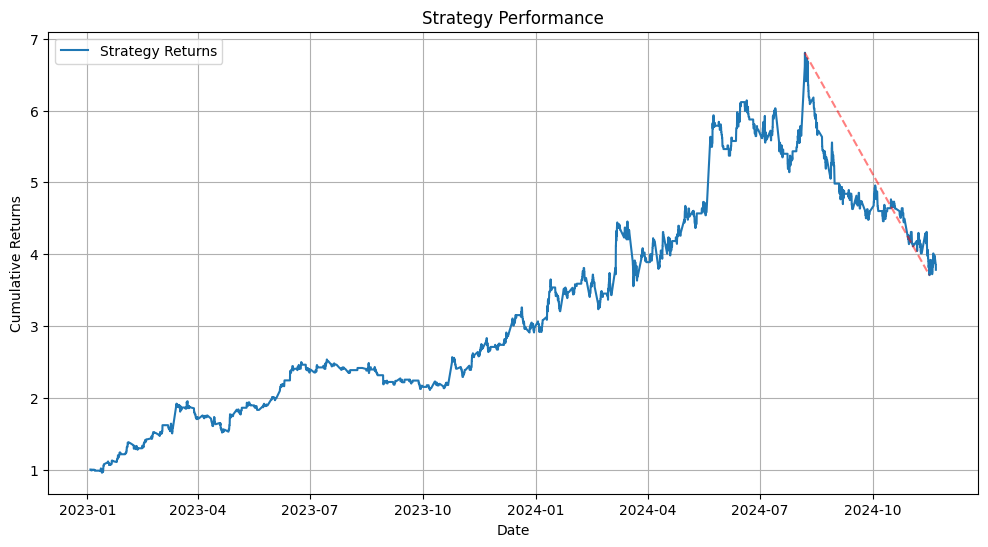

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_daily_std(df):
    df['date'] = pd.to_datetime(df['date'])
    
    daily_returns = df.set_index('date').resample('D')['cumulative_returns'].last()
    daily_pct_change = daily_returns.pct_change(fill_method=None).dropna()
    
    daily_std = daily_pct_change.std()
    
    return daily_std * 100

def calculate_max_drawdown(cumulative_returns_input, dates):

    cumulative_returns = cumulative_returns_input.copy()
    max_drawdown = float('-inf')
    peak = cumulative_returns.iloc[0]
    peak_idx = 0
    curr_peak_idx = 0
    trough_idx = 0
    
    for i in range(len(cumulative_returns)):
        curr_value = cumulative_returns.iloc[i]

        if curr_value > peak:
            peak = curr_value
            curr_peak_idx = i

        drawdown = (peak - curr_value) / peak
        
        if drawdown > max_drawdown:
            max_drawdown = drawdown
            peak_idx = curr_peak_idx
            trough_idx = i
    
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Peak Index: {peak_idx}, Peak Value: {cumulative_returns.iloc[peak_idx]:.4f}, date: {dates.iloc[peak_idx].strftime('%Y-%m-%d')}")
    print(f"Trough Index: {trough_idx}, Trough Value: {cumulative_returns.iloc[trough_idx]:.4f}, date: {dates.iloc[trough_idx].strftime('%Y-%m-%d')}")
    
    return max_drawdown, peak_idx, trough_idx

def print_performance(strategy_df, total_return, max_drawdown, peak_idx, trough_idx):
    total_days = len(strategy_df['cumulative_returns'])
    cagr = (1 + total_return)**(252/total_days) - 1 #OKX only published on public trading days
    calmar_ratio = abs(cagr/max_drawdown)

    plt.figure(figsize=(12,6))
    plt.plot(strategy_df['date'], strategy_df['cumulative_returns'], label='Strategy Returns')
    plt.plot([strategy_df['date'].iloc[peak_idx], strategy_df['date'].iloc[trough_idx]], 
    [strategy_df['cumulative_returns'].iloc[peak_idx], strategy_df['cumulative_returns'].iloc[trough_idx]], 
    'r--', alpha=0.5)
    plt.title('Strategy Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.legend()

    # Print metrics
    metrics = {
    'Total Return':  str(round(total_return,3))+ " %",
    'CAGR': str(round(cagr*100,3))+ " %",
    'Daily Sharpe Ratio':round(sharpe_ratio,3),
    'Maximum Drawdown': str(round(max_drawdown*-100,3))+ " %",
    'Calmar Ratio': str(round(calmar_ratio,3)),
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value}")

    plt.show()

trigger_pnl = 0.2  # Enter when BTC moves 0.5%
target_profit = 0.9  # Take profit at 1%
stop_loss = 0.6  # Stop loss at 0.6%

file1 = "./binance_data/usdt_btc_1h.csv"
file2 = "./okx_data/eth_usdt_1h.csv"
output_file = "./results/strategy_results.csv"

btc_df = pd.read_csv(file1)
eth_df = pd.read_csv(file2)

btc_df['date'] = pd.to_datetime(btc_df['date'], format='mixed')
eth_df['date'] = pd.to_datetime(eth_df['date'], format='mixed')

btc_df = btc_df.sort_values('date').reset_index(drop=True)
eth_df = eth_df.sort_values('date').reset_index(drop=True)
    

strategy_df, total_return  = create_strategy_df(btc_df, eth_df, trigger_pnl, target_profit, stop_loss, output_file, save_result=True)
max_drawdown, peak_idx, trough_idx=calculate_max_drawdown(strategy_df['cumulative_returns'], strategy_df['date'])
sharpe_ratio = (total_return/ calculate_daily_std(strategy_df))
print_performance(strategy_df, total_return, max_drawdown, peak_idx, trough_idx)

